In [1]:
import os 
import yaml 
import shutil 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
import xml.etree.ElementTree as ET 

from xml.dom.minidom import parse 
from IPython.display import Image 
from sklearn.model_selection import train_test_split 

In [2]:
IMG_DIR = "../data/images" 
ANNOT_DIR = "../data/Annotations" 

In [3]:
img_file = "hard_hat_workers2.png"
annot_file = "hard_hat_workers2.xml"

with open(os.path.join(ANNOT_DIR, annot_file), "r") as f:
    xml_data = f.read()

print(xml_data)


<annotation>
    <folder>images</folder>
    <filename>hard_hat_workers2.png</filename>
    <size>
        <width>416</width>
        <height>415</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>329</xmin>
            <ymin>216</ymin>
            <xmax>360</xmax>
            <ymax>245</ymax>
        </bndbox>
    </object>
    <object>
        <name>helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>298</xmin>
            <ymin>222</ymin>
            <xmax>323</xmax>
            <ymax>251</ymax>
        </bndbox>
    </object>
</annotation>


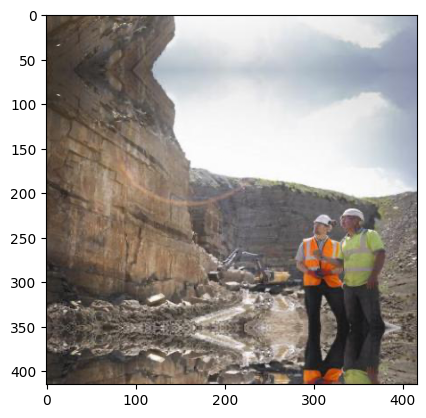

In [4]:
img = plt.imread(os.path.join(IMG_DIR, img_file)) 
plt.imshow(img) 

In [5]:
def plot_box(image_file, annotation_file):
    # Load the image
    image = plt.imread(image_file)

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Parse the XML annotation file
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    # Iterate over each object in the annotation
    for obj in root.findall('object'):
        # Get the object label
        label = obj.find('name').text

        # Get the bounding box coordinates
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Create a rectangle patch
        rect = mpatches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle patch to the axes
        ax.add_patch(rect)

        # Add the label as text
        ax.text(xmin, ymin, label, fontsize=7, color='r', verticalalignment='baseline', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

    # Show the plot
    plt.show()

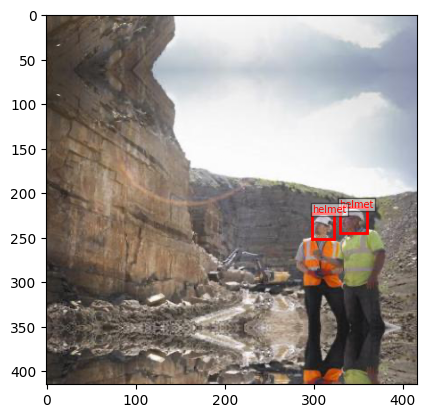

In [6]:
# Function call
plot_box(os.path.join(IMG_DIR, img_file), os.path.join(ANNOT_DIR, annot_file))

In [7]:
images_names = os.listdir(IMG_DIR) 

In [8]:
train_lst, test_lst = train_test_split(images_names, test_size=0.2, shuffle=True, random_state=10) 
train_lst, val_lst = train_test_split(train_lst, test_size=0.15, shuffle=True, random_state=10) 

In [9]:
def copy_files(file_list, source_folder, target_folder):
    # create needed directories
    os.makedirs(target_folder, exist_ok=True)
    for file in file_list:
        # copy image to the target folder
        shutil.copy(os.path.join(source_folder, file), target_folder)

In [10]:
# Copy files to train, val, and test directories
copy_files(train_lst, IMG_DIR, os.path.join(IMG_DIR, 'train'))
copy_files(val_lst, IMG_DIR, os.path.join(IMG_DIR, 'val'))
copy_files(test_lst, IMG_DIR, os.path.join(IMG_DIR, 'test'))

In [11]:
classes = ['helmet','head','person'] 

In [12]:
config = {
   "path": r"../data/images",
   "train": "train",
   "val": "val",
   "test": "test",
   "nc": 3,
   "names": classes
}

In [13]:
with open("../data.yaml", "w") as file:
       yaml.dump(config, file, default_flow_style=False)

In [14]:
def convert_annot(size , box):
    # Get the four attributes to specified variables
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])
    
    # Calculate the new four attributes 
    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    # Calculate the normalizing factors
    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    # Normalize the calculated values
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh

    # Return a list with the new values
    return [x, y, w, h]

In [15]:
def save_txt_file(target_path, img_jpg_file_name, size, img_box):
    save_file_name = os.path.join(target_path, f"{img_jpg_file_name}.txt")
    with open(save_file_name, 'a+') as file_path:
        for box in img_box:
            # get the index of the class
            cls_num = classes.index(box[0])
            # calculate the new annotations
            new_box = convert_annot(size, box[1:])
            # write them to a string and append it to the open file
            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [16]:
def get_xml_data(file_path, img_xml_file, target_path):
    img_path = os.path.join(file_path, f"{img_xml_file}.xml")
    root = parse(img_path).documentElement
    # get the image size
    img_size = root.getElementsByTagName("size")[0]    
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    
    # get the boxes
    objects = root.getElementsByTagName("object")   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        img_box.append([cls_name, x1, y1, x2, y2])
  
    save_txt_file(target_path, img_xml_file, [img_w, img_h], img_box)

In [17]:
# Add folder to save the new annotations
LABELS_DIR = "../data/labels"
# list of subdirectories for the splits
dirs = ['train', 'val', 'test']

# Change annotations to text files
for folder in dirs:
    img_path = os.path.join(IMG_DIR, folder)
    files = os.listdir(img_path)
    target_folder = os.path.join(LABELS_DIR, folder)
    os.makedirs(target_folder, exist_ok=True)
    for file in files:
        file_xml = file.split(".")
        get_xml_data(ANNOT_DIR, file_xml[0], target_folder)